## Wybrane parametry fizjologiczne w chorobach serca w zależności od płci i wieku

Dane zaczerpnięto z bazy naukowej pobranej ze strony Kaggle ze zbioru "Heart Disease UCI" zawierającej informacje o osobach z chorobami serca i osobach bez takich chorób.
Analizie poddano maksymalną częstość akcji serca, spoczynkowe ciśnienie krwi oraz stężenie cholesterolu w surowicy krwi. 
Celem analizy było: 
<ol>
<li>określenie statystyk badanych parametrów w grupie osób z chorobami serca i w grupie kontrolnej, </li>
<li>różnic badanych parametrów w zależności od płci w grupie osób z chorobami serca i w grupie kontrolnej, </li>
<li>korelacji badanych parametrów w zależności od wieku, </li>
<li>prawdopodobieństwa występowania chorób serca w zależności od badanych parametrów. </li>

</ol>




Czyszczenie danych

Dane dla osób w wieku 29-33 lata oraz 71-75 lat odrzucono ponieważ nie było dla tych kategorii wiekowych żadnych danych lub były dane dotyczące jednej osoby. W ten sposób uzyskano zbiór danych dla osób z przedziału wiekowego 34-71 lat dla których było co najmniej 2 dane w każdej kategorii wiekowej. Łącznie analizie poddano 126 danych osób z chorobami serca i 173 danych osób grupy kontrolnej. Analizowano 31 kobiet  i 95 mężczyzn z chorobami serca.



In [29]:
import sqlite3
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from statistics import mean, median
from numpy import quantile
from numpy import var, std
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from scipy.stats import shapiro

In [58]:
con = sqlite3.connect("data.db")
cur = con.cursor()

cur.execute('''CREATE TABLE heart
               (age, sex, trestbps, chol, thalach, ca)''')

a_file = open(r"/home/kgwiazda/Desktop/heart.csv")
rows = csv.reader(a_file)


arr = list(rows)
for i in range(1, len(arr)):
    if 34<=int(arr[i][0])<=71:
        cur.execute(f"INSERT INTO heart VALUES ({int(arr[i][0])},{int(arr[i][1])}, {int(arr[i][3])}, {int(arr[i][4])}, {int(arr[i][7])}, {int(arr[i][11])})")

rows = list(cur.execute("select * from heart"))

con.commit()
con.close()

OperationalError: table heart already exists

Badanie rozkładu danych

Zbadano rozkład badanych parametrów testem Shapiro-Wilka w grupie osób z chorobami serca i w grupie kontrolnej.


In [31]:
def get_data(n, param=-1):
    if param==-1:
        data0 = [row[n] for row in rows if row[5] == 0]
        data1234 = [row[n] for row in rows if row[5] != 0]
        return data0, data1234
    data0 = [row[n] for row in rows if row[5] == 0 and row[1] == param]
    data1234 = [row[n] for row in rows if row[5] != 0 and row[1] == param]
    return data0, data1234


age = {i:[] for i in range(34, 72)}

for row in rows:
    if row[5]==0:continue
    age[row[0]].append(row)


trestbps0, trestbps1234 = get_data(2)
chol0, chol1234 = get_data(3)
thalach0, thalach1234 = get_data(4)

trestbps_men0, trestbps_men1234 = get_data(2, 1)
chol_men0, chol_men1234 = get_data(3, 1)
thalach_men0, thalach_men1234 = get_data(4, 1)

trestbps_women0, trestbps_women1234 = get_data(2, 0)
chol_women0, chol_women1234 = get_data(3, 0)
thalach_women0, thalach_women1234 = get_data(4, 0)

_, p1 = shapiro(trestbps0)
_, p2 = shapiro(trestbps1234)
_, p3 = shapiro(chol0)
_, p4 = shapiro(chol1234)
_, p5 = shapiro(thalach0)
_, p6 = shapiro(thalach1234)

E = 0.05
def normal(p):
    if p<=E: print("Rozkład nie jest normalny")
    else: print("Rozkład jest normalny")

        
normal(p1)
normal(p2)
normal(p3)
normal(p4)
normal(p5)
normal(p6)

Rozkład nie jest normalny
Rozkład nie jest normalny
Rozkład nie jest normalny
Rozkład nie jest normalny
Rozkład nie jest normalny
Rozkład nie jest normalny


<ul>
<li>Wynik testu pokazał, że rozkład danych maksymalnej częstości akcji serca nie jest normalny zarówno w grupie osób z chorobami serca jak i w grupie kontrolnej. </li>
<li>Wynik testu pokazał, że  rozkład danych spoczynkowego ciśnienia krwi nie jest normalny zarówno w grupie osób z chorobami serca jak i w grupie kontrolnej. </li>
<li>Wynik testu pokazał, że  rozkład danych stężenia cholesterolu w surowicy krwi nie jest normalny zarówno w grupie osób z chorobami serca jak i w grupie kontrolnej. </li>
</ul>
W związku z tym w dalszej analizę zastosowano statystyki i testy nieparametryczne.


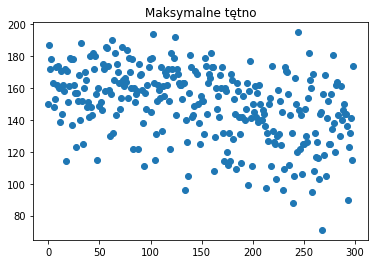

In [32]:
thalach = [x[4] for x in rows]

n = len(thalach)
arr = [i for i in range(n)]

plt.scatter(arr, thalach)
plt.title("Maksymalne tętno")
plt.show()

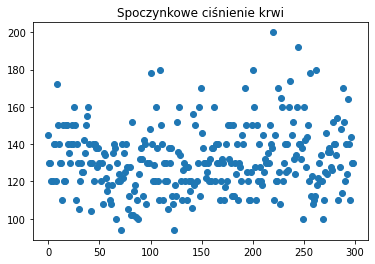

In [33]:
trestbps = [x[2] for x in rows]

n = len(trestbps)
arr = [i for i in range(n)]

plt.scatter(arr, trestbps)
plt.title("Spoczynkowe ciśnienie krwi")
plt.show()

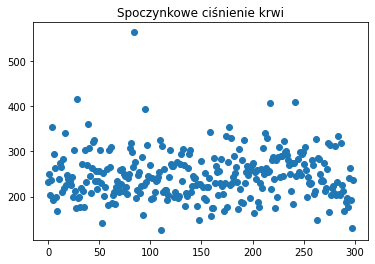

In [34]:
chol = [x[3] for x in rows]

n = len(chol)
arr = [i for i in range(n)]

plt.scatter(arr, chol)
plt.title("Spoczynkowe ciśnienie krwi")
plt.show()

Statystyki opisowe

Określono medianę, kwartyle 1 i 3 oraz zakres dla badanych parametrów zarówno dla osób chorych na serce jak i dla grupy kontrolnej. Podano dodatkowo średnie, wariancje i odchylenie standardowe, które są statystykami dla danych z rozkładem normalnym.


In [35]:
def get_min_max(data0, data1234):
    min_data0, max_data0 = min(data0), max(data0)
    min_data1234, max_data1234 = min(data1234), max(data1234)
    return min_data0, max_data0, min_data1234, max_data1234

def get_mean(data0, data1234):
    return mean(data0), mean(data1234)

def get_median(data0, data1234):
    return median(data0), median(data1234)

def get_quantile(data0, data1234, param):
    return quantile(data0, param), quantile(data1234, param)

def get_var(data0, data1234):
    return var(data0), var(data1234)

def get_std(data0, data1234):
    return std(data0), std(data1234)


#min max
min_thalach0, max_thalach0, min_thalach1234, max_thalach1234 = \
    get_min_max(thalach0, thalach1234)
min_chol0, max_chol0, min_chol1234, max_chol1234 = \
    get_min_max(chol0, chol1234)
min_trestbps0, max_trestbps0, min_trestbps1234, max_trestbps1234 = \
    get_min_max(trestbps0, trestbps1234)

#mean
mean_thalach0, mean_thalach1234 = get_mean(thalach0, thalach1234)
mean_chol0, mean_chol1234 = get_mean(chol0, chol1234)
mean_trestbps0, mean_trestbps1234 = get_mean(trestbps0, trestbps1234)

#median
median_thalach0, median_thalach1234 = get_median(thalach0, thalach1234)
median_chol0, median_chol1234 = get_median(chol0, chol1234)
median_trestbps0, median_trestbps1234 = get_median(trestbps0, trestbps1234)

#quantiles
quantile1_thalach0, quantile1_thalach1234 = get_quantile(thalach0, thalach1234, 0.25)
quantile1_chol0, quantile1_chol1234 = get_quantile(chol0, chol1234, 0.25)
quantile1_trestbps0, quantile1_trestbps1234 = get_quantile(trestbps0, trestbps1234, 0.25)
quantile3_thalach0, quantile3_thalach1234 = get_quantile(thalach0, thalach1234,0.75)
quantile3_chol0, quantile3_chol1234 = get_quantile(chol0, chol1234,0.75)
quantile3_trestbps0, quantile3_trestbps1234 = get_quantile(trestbps0, trestbps1234,0.75)

#var
var_thalach0, var_thalach1234 = get_var(thalach0, thalach1234)
var_chol0, var_chol1234 = get_var(chol0, chol1234)
var_trestbps0, var_trestbps1234 = get_var(trestbps0, trestbps1234)

#std
std_thalach0, std_thalach1234 = get_std(thalach0, thalach1234)
std_chol0, std_chol1234 = get_std(chol0, chol1234)
std_trestbps0, std_trestbps1234 = get_std(trestbps0, trestbps1234)



In [36]:
print(f"Średnie maksymalne tętno u grupy kontrolnej: {mean_thalach0}")
print(f"Średnie maksymalne tętno u osób z chorobami serca: {mean_thalach1234}")

print(f"Średni cholesterol w surowicy krwi w mg/dl u grupy kontrolnej: {mean_chol0}")
print(f"Średni cholesterol w surowicy krwi w mg/dl u osób z chorobami serca: {mean_chol1234}")

print(f"Średnie spoczynkowe ciśnienie krwi u grupy kontrolnej: {mean_trestbps0}")
print(f"Średnie spoczynkowe ciśnienie krwi u osób z chorobami serca: {mean_trestbps1234}")

print()

print(f"Wariancja maksymalnego tętno u grupy kontrolnej: {var_thalach0}")
print(f"Wariancja maksymalnego tętno u osób z chorobami serca: {var_thalach1234}")

print(f"Wariancja cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: {var_chol0}")
print(f"Wariancja cholesterolu w surowicy krwi w mg/dl u osób z chorobami serca: {var_chol1234}")

print(f"Wariancja spoczynkowego ciśnienie krwi u grupy kontrolnej: {var_trestbps0}")
print(f"Wariancja spoczynkowego ciśnienie krwi u osób z chorobami serca: {var_trestbps1234}")

print()

print(f"Odchylenie standardowe maksymalnego tętno u grupy kontrolnej: {std_thalach0}")
print(f"Odchylenie standardowe maksymalnego tętno u osób z chorobami serca: {std_thalach1234}")

print(f"Odchylenie standardowe cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: {std_chol0}")
print(f"Odchylenie standardowe cholesterolu w surowicy krwi w mg/dl u osób z chorobami serca: {std_chol1234}")

print(f"Odchylenie standardowe spoczynkowego ciśnienie krwi u grupy kontrolnej: {std_trestbps0}")
print(f"Odchylenie standardowe spoczynkowego ciśnienie krwi u osób z chorobami serca: {std_trestbps1234}")


Średnie maksymalne tętno u grupy kontrolnej: 154.94219653179192
Średnie maksymalne tętno u osób z chorobami serca: 142.35714285714286
Średni cholesterol w surowicy krwi w mg/dl u grupy kontrolnej: 243.1849710982659
Średni cholesterol w surowicy krwi w mg/dl u osób z chorobami serca: 250.5793650793651
Średnie spoczynkowe ciśnienie krwi u grupy kontrolnej: 130.7514450867052
Średnie spoczynkowe ciśnienie krwi u osób z chorobami serca: 132.9126984126984

Wariancja maksymalnego tętno u grupy kontrolnej: 443.54579170704
Wariancja maksymalnego tętno u osób z chorobami serca: 518.3883219954648
Wariancja cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: 2782.8906411841353
Wariancja cholesterolu w surowicy krwi w mg/dl u osób z chorobami serca: 2522.307193247669
Wariancja spoczynkowego ciśnienie krwi u grupy kontrolnej: 296.4411106284875
Wariancja spoczynkowego ciśnienie krwi u osób z chorobami serca: 325.50825144872755

Odchylenie standardowe maksymalnego tętno u grupy kontrolnej: 21.060

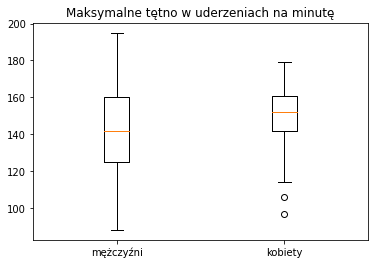

In [37]:
data = [thalach_men1234, thalach_women1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Maksymalne tętno w uderzeniach na minutę")
plt.xticks([1,2], ["mężczyźni", "kobiety"])
plt.show()

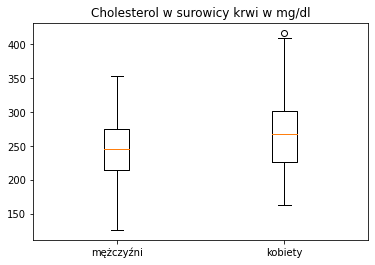

In [38]:
data = [chol_men1234, chol_women1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Cholesterol w surowicy krwi w mg/dl")
plt.xticks([1,2], ["mężczyźni", "kobiety"])
plt.show()

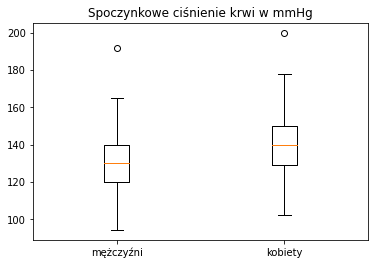

In [39]:
data = [trestbps_men1234, trestbps_women1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Spoczynkowe ciśnienie krwi w mmHg")
plt.xticks([1,2], ["mężczyźni", "kobiety"])
plt.show()

Określono medianę, kwartyle 1 i 3 oraz zakres dla badanych parametrów zarówno dla kobiet i mężczyzn z chorobami serca. Podano dodatkowo średnie, wariancje i odchylenie standardowe, które są statystykami dla danych z rozkładem normalnym.

In [40]:
#min max
min_thalach_men0, max_thalach_men0, min_thalach_men1234, max_thalach_men1234 = \
    get_min_max(thalach_men0, thalach_men1234)
min_chol_men0, max_chol_men0, min_chol_men1234, max_chol_men1234 = \
    get_min_max(chol_men0, chol_men1234)
min_trestbps_men0, max_trestbps_men0, min_trestbps_men1234, max_trestbps_men1234 = \
    get_min_max(trestbps_men0, trestbps_men1234)

#mean
mean_thalach_men0, mean_thalach_men1234 = get_mean(thalach_men0, thalach_men1234)
mean_chol_men0, mean_chol_men1234 = get_mean(chol_men0, chol_men1234)
mean_trestbps_men0, mean_trestbps_men1234 = get_mean(trestbps_men0, trestbps_men1234)

#median
median_thalach_men0, median_thalach_men1234 = get_median(thalach_men0, thalach_men1234)
median_chol_men0, median_chol_men1234 = get_median(chol_men0, chol_men1234)
median_trestbps_men0, median_trestbps_men1234 = get_median(trestbps_men0, trestbps_men1234)

#quantiles
quantile1_thalach_men0, quantile1_thalach_men1234 = get_quantile(thalach_men0, thalach_men1234, 0.25)
quantile1_chol_men0, quantile1_chol_men1234 = get_quantile(chol_men0, chol_men1234, 0.25)
quantile1_trestbps_men0, quantile1_trestbps_men1234 = get_quantile(trestbps_men0, trestbps_men1234, 0.25)
quantile3_thalach_men0, quantile3_thalach_men1234 = get_quantile(thalach_men0, thalach_men1234,0.75)
quantile3_chol_men0, quantile3_chol_men1234 = get_quantile(chol_men0, chol_men1234,0.75)
quantile3_trestbps_men0, quantile3_trestbps_men1234 = get_quantile(trestbps_men0, trestbps_men1234,0.75)

#var
var_thalach_men0, var_thalach_men1234 = get_var(thalach_men0, thalach_men1234)
var_chol_men0, var_chol_men1234 = get_var(chol_men0, chol_men1234)
var_trestbps_men0, var_trestbps_men1234 = get_var(trestbps_men0, trestbps_men1234)

#std
std_thalach_men0, std_thalach_men1234 = get_std(thalach_men0, thalach_men1234)
std_chol_men0, std_chol_men1234 = get_std(chol_men0, chol_men1234)
std_trestbps_men0, std_trestbps_men1234 = get_std(trestbps_men0, trestbps_men1234)



In [41]:
print(f"Średnie maksymalne tętno u grupy kontrolnej: {mean_thalach_men0}")
print(f"Średnie maksymalne tętno u mężczyzn z chorobami serca: {mean_thalach_men1234}")

print(f"Średni cholesterol w surowicy krwi w mg/dl u grupy kontrolnej: {mean_chol_men0}")
print(f"Średni cholesterol w surowicy krwi w mg/dl u mężczyzn z chorobami serca: {mean_chol_men1234}")

print(f"Średnie spoczynkowe ciśnienie krwi u grupy kontrolnej: {mean_trestbps_men0}")
print(f"Średnie spoczynkowe ciśnienie krwi u mężczyzn z chorobami serca: {mean_trestbps_men1234}")

print()

print(f"Wariancja maksymalnego tętno u grupy kontrolnej: {var_thalach_men0}")
print(f"Wariancja maksymalnego tętno u mężczyzn z chorobami serca: {var_thalach_men1234}")

print(f"Wariancja cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: {var_chol_men0}")
print(f"Wariancja cholesterolu w surowicy krwi w mg/dl u mężczyzn z chorobami serca: {var_chol_men1234}")

print(f"Wariancja spoczynkowego ciśnienie krwi u grupy kontrolnej: {var_trestbps_men0}")
print(f"Wariancja spoczynkowego ciśnienie krwi u mężczyzn z chorobami serca: {var_trestbps_men1234}")

print()

print(f"Odchylenie standardowe maksymalnego tętno u grupy kontrolnej: {std_thalach_men0}")
print(f"Odchylenie standardowe maksymalnego tętno u mężczyzn z chorobami serca: {std_thalach_men1234}")

print(f"Odchylenie standardowe cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: {std_chol_men0}")
print(f"Odchylenie standardowe cholesterolu w surowicy krwi w mg/dl u mężczyzn z chorobami serca: {std_chol_men1234}")

print(f"Odchylenie standardowe spoczynkowego ciśnienie krwi u grupy kontrolnej: {std_trestbps_men0}")
print(f"Odchylenie standardowe spoczynkowego ciśnienie krwi u mężczyzn z chorobami serca: {std_trestbps_men1234}")

Średnie maksymalne tętno u grupy kontrolnej: 155.93636363636364
Średnie maksymalne tętno u mężczyzn z chorobami serca: 140.18947368421053
Średni cholesterol w surowicy krwi w mg/dl u grupy kontrolnej: 235.15454545454546
Średni cholesterol w surowicy krwi w mg/dl u mężczyzn z chorobami serca: 243.76842105263157
Średnie spoczynkowe ciśnienie krwi u grupy kontrolnej: 131.04545454545453
Średnie spoczynkowe ciśnienie krwi u mężczyzn z chorobami serca: 130.90526315789472

Wariancja maksymalnego tętno u grupy kontrolnej: 476.9868595041322
Wariancja maksymalnego tętno u mężczyzn z chorobami serca: 545.6904155124653
Wariancja cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: 1640.2761157024795
Wariancja cholesterolu w surowicy krwi w mg/dl u mężczyzn z chorobami serca: 1972.6200554016618
Wariancja spoczynkowego ciśnienie krwi u grupy kontrolnej: 292.78884297520665
Wariancja spoczynkowego ciśnienie krwi u mężczyzn z chorobami serca: 262.31734072022164

Odchylenie standardowe maksymalnego 

In [42]:
#min max
min_thalach_women0, max_thalach_women0, min_thalach_women1234, max_thalach_women1234 = \
    get_min_max(thalach_women0, thalach_women1234)
min_chol_women0, max_chol_women0, min_chol_women1234, max_chol_women1234 = \
    get_min_max(chol_women0, chol_women1234)
min_trestbps_women0, max_trestbps_women0, min_trestbps_women1234, max_trestbps_women1234 = \
    get_min_max(trestbps_women0, trestbps_women1234)

#mean
mean_thalach_women0, mean_thalach_women1234 = get_mean(thalach_women0, thalach_women1234)
mean_chol_women0, mean_chol_women1234 = get_mean(chol_women0, chol_women1234)
mean_trestbps_women0, mean_trestbps_women1234 = get_mean(trestbps_women0, trestbps_women1234)

#median
median_thalach_women0, median_thalach_women1234 = get_median(thalach_women0, thalach_women1234)
median_chol_women0, median_chol_women1234 = get_median(chol_women0, chol_women1234)
median_trestbps_women0, median_trestbps_women1234 = get_median(trestbps_women0, trestbps_women1234)

#quantiles
quantile1_thalach_women0, quantile1_thalach_women1234 = get_quantile(thalach_women0, thalach_women1234, 0.25)
quantile1_chol_women0, quantile1_chol_women1234 = get_quantile(chol_women0, chol_women1234, 0.25)
quantile1_trestbps_women0, quantile1_trestbps_women1234 = get_quantile(trestbps_women0, trestbps_women1234, 0.25)
quantile3_thalach_women0, quantile3_thalach_women1234 = get_quantile(thalach_women0, thalach_women1234,0.75)
quantile3_chol_women0, quantile3_chol_women1234 = get_quantile(chol_women0, chol_women1234,0.75)
quantile3_trestbps_women0, quantile3_trestbps_women1234 = get_quantile(trestbps_women0, trestbps_women1234,0.75)

#var
var_thalach_women0, var_thalach_women1234 = get_var(thalach_women0, thalach_women1234)
var_chol_women0, var_chol_women1234 = get_var(chol_women0, chol_women1234)
var_trestbps_women0, var_trestbps_women1234 = get_var(trestbps_women0, trestbps_women1234)

#std
std_thalach_women0, std_thalach_women1234 = get_std(thalach_women0, thalach_women1234)
std_chol_women0, std_chol_women1234 = get_std(chol_women0, chol_women1234)
std_trestbps_women0, std_trestbps_women1234 = get_std(trestbps_women0, trestbps_women1234)



In [43]:
print(f"Średnie maksymalne tętno u grupy kontrolnej: {mean_thalach_women0}")
print(f"Średnie maksymalne tętno u kobiet z chorobami serca: {mean_thalach_women1234}")

print(f"Średni cholesterol w surowicy krwi w mg/dl u grupy kontrolnej: {mean_chol_women0}")
print(f"Średni cholesterol w surowicy krwi w mg/dl u kobiet z chorobami serca: {mean_chol_women1234}")

print(f"Średnie spoczynkowe ciśnienie krwi u grupy kontrolnej: {mean_trestbps_women0}")
print(f"Średnie spoczynkowe ciśnienie krwi u kobiet z chorobami serca: {mean_trestbps_women1234}")

print()

print(f"Wariancja maksymalnego tętno u grupy kontrolnej: {var_thalach_women0}")
print(f"Wariancja maksymalnego tętno u kobiet z chorobami serca: {var_thalach_women1234}")

print(f"Wariancja cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: {var_chol_women0}")
print(f"Wariancja cholesterolu w surowicy krwi w mg/dl u kobiet z chorobami serca: {var_chol_women1234}")

print(f"Wariancja spoczynkowego ciśnienie krwi u grupy kontrolnej: {var_trestbps_women0}")
print(f"Wariancja spoczynkowego ciśnienie krwi u kobiet z chorobami serca: {var_trestbps_women1234}")

print()

print(f"Odchylenie standardowe maksymalnego tętno u grupy kontrolnej: {std_thalach_women0}")
print(f"Odchylenie standardowe maksymalnego tętno u kobiet z chorobami serca: {std_thalach_women1234}")

print(f"Odchylenie standardowe cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: {std_chol_women0}")
print(f"Odchylenie standardowe cholesterolu w surowicy krwi w mg/dl u kobiet z chorobami serca: {std_chol_women1234}")

print(f"Odchylenie standardowe spoczynkowego ciśnienie krwi u grupy kontrolnej: {std_trestbps_women0}")
print(f"Odchylenie standardowe spoczynkowego ciśnienie krwi u kobiet z chorobami serca: {std_trestbps_women1234}")

Średnie maksymalne tętno u grupy kontrolnej: 153.20634920634922
Średnie maksymalne tętno u kobiet z chorobami serca: 149
Średni cholesterol w surowicy krwi w mg/dl u grupy kontrolnej: 257.2063492063492
Średni cholesterol w surowicy krwi w mg/dl u kobiet z chorobami serca: 271.4516129032258
Średnie spoczynkowe ciśnienie krwi u grupy kontrolnej: 130.23809523809524
Średnie spoczynkowe ciśnienie krwi u kobiet z chorobami serca: 139.06451612903226

Wariancja maksymalnego tętno u grupy kontrolnej: 380.41773746535654
Wariancja maksymalnego tętno u kobiet z chorobami serca: 376.19354838709677
Wariancja cholesterolu w surowicy krwi w mg/dl u grupy kontrolnej: 4468.735197782816
Wariancja cholesterolu w surowicy krwi w mg/dl u kobiet z chorobami serca: 3629.0218522372534
Wariancja spoczynkowego ciśnienie krwi u grupy kontrolnej: 302.4036281179138
Wariancja spoczynkowego ciśnienie krwi u kobiet z chorobami serca: 468.9635796045786

Odchylenie standardowe maksymalnego tętno u grupy kontrolnej: 19.5

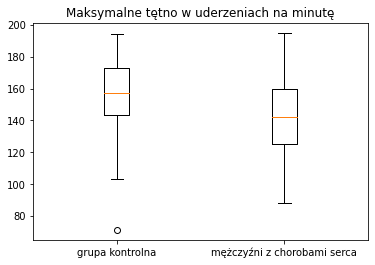

In [44]:
data = [thalach_men0, thalach_men1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Maksymalne tętno w uderzeniach na minutę")
plt.xticks([1,2], ["grupa kontrolna", "mężczyźni z chorobami serca"])
plt.show()

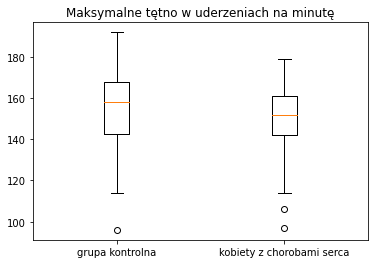

In [45]:
data = [thalach_women0, thalach_women1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Maksymalne tętno w uderzeniach na minutę")
plt.xticks([1,2], ["grupa kontrolna", "kobiety z chorobami serca"])
plt.show()

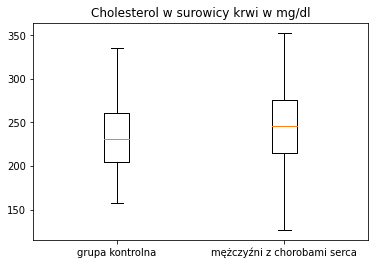

In [46]:
data = [chol_men0, chol_men1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Cholesterol w surowicy krwi w mg/dl")
plt.xticks([1,2], ["grupa kontrolna", "mężczyźni z chorobami serca"])
plt.show()

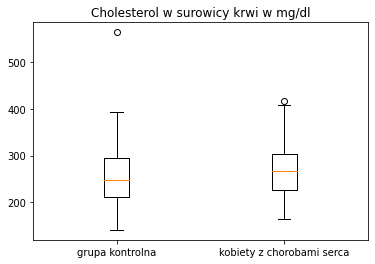

In [47]:
data = [chol_women0, chol_women1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Cholesterol w surowicy krwi w mg/dl")
plt.xticks([1,2], ["grupa kontrolna", "kobiety z chorobami serca"])
plt.show()

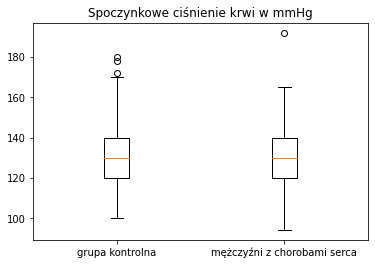

In [48]:
data = [trestbps_men0, trestbps_men1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Spoczynkowe ciśnienie krwi w mmHg")
plt.xticks([1,2], ["grupa kontrolna", "mężczyźni z chorobami serca"])
plt.show()

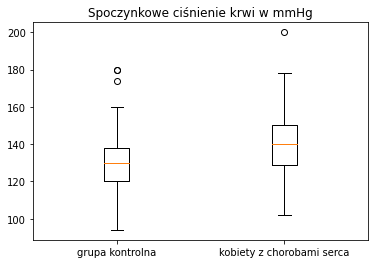

In [49]:
data = [trestbps_women0, trestbps_women1234]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.title("Spoczynkowe ciśnienie krwi w mmHg")
plt.xticks([1,2], ["grupa kontrolna", "kobiety z chorobami serca"])
plt.show()

Różnice w badanych parametrach pomiędzy kobietami i mężczyznami w grupie osób z chorobami serca oraz pomiędzy grupą badaną i kontrolną.

Zastosowano test Manna-Whitney’a.
Uzyskano następujące wyniki testu:


In [50]:
_, thalach_mannwhitneyu =  mannwhitneyu(thalach_men1234, thalach_women1234)
_, chol_mannwhitneyu =  mannwhitneyu(chol_men1234, chol_women1234)
_, trestbps_mannwhitneyu =  mannwhitneyu(trestbps_men1234, trestbps_women1234)

_, thalach_mannwhitneyu_men =  mannwhitneyu(thalach_men0, thalach_men1234)
_, chol_mannwhitneyu_men =  mannwhitneyu(chol_men0, chol_men1234)
_, trestbps_mannwhitneyu_men =  mannwhitneyu(trestbps_men0, trestbps_men1234)

_, thalach_mannwhitneyu_women =  mannwhitneyu(thalach_women0, thalach_women1234)
_, chol_mannwhitneyu_women =  mannwhitneyu(chol_women0, chol_women1234)
_, trestbps_mannwhitneyu_women =  mannwhitneyu(trestbps_women0, trestbps_women1234)

In [51]:
print(f"Porównanie maksymalnego tętna u kobiet i mężczyzn: {thalach_mannwhitneyu}")
print(f"Porównanie maksymalnego tętna u kobiet z grupy kontrolnej oraz cierpiących na choroby serca: {thalach_mannwhitneyu_women}")
print(f"Porównanie maksymalnego tętna u mężczyzn z grupy kontrolnej oraz cierpiących na choroby serca: {thalach_mannwhitneyu_men}")
print()
print(f"Porównanie spoczynkowego ciśnienia krwi u kobiet i mężczyzn: {trestbps_mannwhitneyu}")
print(f"Porównanie spoczynkowego ciśnienia krwi u kobiet z grupy kontrolnej oraz cierpiących na choroby serca: {trestbps_mannwhitneyu_women}")
print(f"Porównanie spoczynkowego ciśnienia krwi u mężczyzn z grupy kontrolnej oraz cierpiących na choroby serca: {trestbps_mannwhitneyu_men}")
print()
print(f"Porównanie ilości cholesterol w surowicy krwi u kobiet i mężczyzn: {thalach_mannwhitneyu}")
print(f"Porównanie ilości cholesterol w surowicy krwi u kobiet z grupy kontrolnej oraz cierpiących na choroby serca: {chol_mannwhitneyu_women}")
print(f"Porównanie ilości cholesterol w surowicy krwi u mężczyzn z grupy kontrolnej oraz cierpiących na choroby serca: {chol_mannwhitneyu_men}")

Porównanie maksymalnego tętna u kobiet i mężczyzn: 0.048010767901179946
Porównanie maksymalnego tętna u kobiet z grupy kontrolnej oraz cierpiących na choroby serca: 0.23211914673144696
Porównanie maksymalnego tętna u mężczyzn z grupy kontrolnej oraz cierpiących na choroby serca: 1.8298218708779132e-06

Porównanie spoczynkowego ciśnienia krwi u kobiet i mężczyzn: 0.03475474625491099
Porównanie spoczynkowego ciśnienia krwi u kobiet z grupy kontrolnej oraz cierpiących na choroby serca: 0.035375399747754284
Porównanie spoczynkowego ciśnienia krwi u mężczyzn z grupy kontrolnej oraz cierpiących na choroby serca: 0.8109759853488819

Porównanie ilości cholesterol w surowicy krwi u kobiet i mężczyzn: 0.048010767901179946
Porównanie ilości cholesterol w surowicy krwi u kobiet z grupy kontrolnej oraz cierpiących na choroby serca: 0.2500991580848996
Porównanie ilości cholesterol w surowicy krwi u mężczyzn z grupy kontrolnej oraz cierpiących na choroby serca: 0.07757038425688405


<ul>
<li>Kobiety miały niższą maksymalną częstość akcji serca  niż mężczyźni.</li>
<li>Kobiety miały wyższe spoczynkowe ciśnienie krwi niż mężczyźni.</li>
<li>Kobiety miały wyższe stężenia cholesterolu w surowicy krwi niż mężczyźni. </li>
<li>Kobiety z chorobami serca miały niemalże równą maksymalną częstość akcji serca  co kobiety z grupy kontrolnej. </li>
<li>Kobiety z chorobami serca miały wyższe spoczynkowe ciśnienie krwi niż kobiety z grupy kontrolnej. </li>
<li>Kobiety z chorobami serca miały niemalże równe stężenia cholesterolu w surowicy krwi co kobiety z grupy kontrolnej. </li>
<li>Mężczyźni z chorobami serca miały niższą maksymalną częstość akcji serca  niż mężczyźni z grupy kontrolnej. </li>
<li>Mężczyźni z chorobami serca miały niemalże równe spoczynkowe ciśnienie krwi co mężczyźni z grupy kontrolnej. </li>
<li>Mężczyźni z chorobami serca miały wyższe stężenia cholesterolu w surowicy krwi niż mężczyźni z grupy kontrolnej.</li>
</ul>



Zależność pomiędzy badanymi parametrami osób z chorobami serca w zależności od wieku
Zastosowano korelacja Spearmana.

Uzyskano następujące wyniki korelacji:

In [52]:
age2 = []
thalach = []
chol = []
trestbps = []
for key, value in age.items():
    n = len(value)
    if n==0:continue
    for i in range(n):
        age2.append(key)
        trestbps.append(value[i][2])
        chol.append(value[i][3])
        thalach.append(value[i][4])

thalach_spearman = spearmanr(age2, thalach) # jest istotna zależność
chol_spearman = spearmanr(age2, chol)
trestbps_spearman = spearmanr(age2, trestbps) # jest istotna zależność
# print(thalach_spearman)
# print(chol_spearman)
# print(trestbps_spearman)

<ul>
<li>Stwierdzono korelację pomiędzy maksymalną częstością akcji serca w grupie osób z chorobami serca a wiekiem.</li>
<li>Stwierdzono korelację pomiędzy spoczynkowym ciśnieniem krwi w grupie osób z chorobami serca a wiekiem.
</li>
<li>Stwierdzono brak korelacji pomiędzy stężeniem cholesterolu w surowicy krwi w grupie osób z chorobami serca a wiekiem. </li>
</ul>



Estymowanie prawdopodobieństwa choroby serca  przy znanych badanych parametrach w grupie osób z chorobami serca i grupie kontrolnej.

Regresja logistyczna


In [53]:
file = open("file.csv", "w")
header = ["age", "sex", "trestbps", "chol", "thalach", "ca"]
writer  = csv.writer(file)
writer.writerow(header)
writer.writerows(rows)
file.close()

<AxesSubplot:xlabel='thalach', ylabel='ca'>

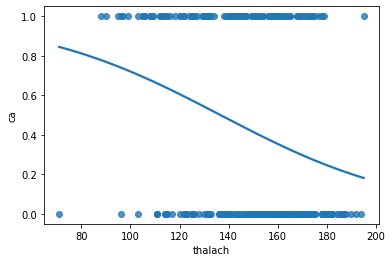

In [54]:
data = pd.read_csv(r"file.csv")
x = data["thalach"]
y = data["ca"]

y = y.replace(2,1)
y = y.replace(3,1)
y = y.replace(4,1)

sns.regplot(x=x, y=y, data=data, logistic=True, ci=None)

<AxesSubplot:xlabel='chol', ylabel='ca'>

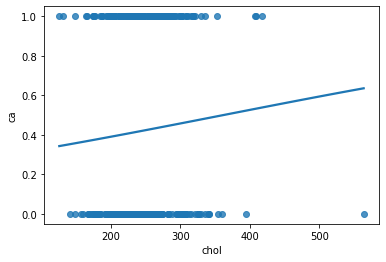

In [55]:
data = pd.read_csv(r"file.csv")
x = data["chol"]
y = data["ca"]

y = y.replace(2,1)
y = y.replace(3,1)
y = y.replace(4,1)

sns.regplot(x=x, y=y, data=data, logistic=True, ci=None)

<AxesSubplot:xlabel='trestbps', ylabel='ca'>

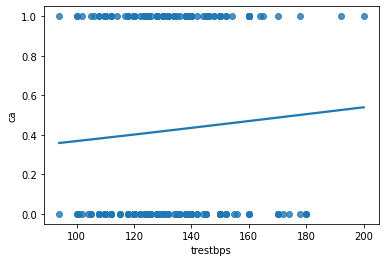

In [56]:
data = pd.read_csv(r"file.csv")
x = data["trestbps"]
y = data["ca"]

y = y.replace(2,1)
y = y.replace(3,1)
y = y.replace(4,1)

sns.regplot(x=x, y=y, data=data, logistic=True, ci=None)

Wnioski

Wyniki pracy pokazały, że żaden z rozkładów badanych parametrów nie był rozkładem normalnym ani dla grupy kontrolnej ani dla grupy z chorobami serca. Zaobserwowano korelację między maksymalną częstością akcji serca w grupie osób z chorobami serca a wiekiem oraz między spoczynkowym ciśnieniem krwi w grupie osób z chorobami serca a wiekiem. 